In [1]:
# Borrowed from: https://pyro.ai/examples/mle_map.html
import utils
import pyro
from torch.distributions import constraints
import pyro.distributions as dist
import matplotlib.pyplot as plt
import torch.distributions.constraints as constraints
import math
import os
import torch
import torch.distributions.constraints as constraints
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from scipy.linalg import circulant
import numpy as np
from pyro.ops.tensor_utils import convolve
from tqdm.notebook import tqdm 

CONV_FLAG = True 
pyro.set_rng_seed(42)
# pyro.enable_validation(True)

In [13]:
# Pretend this is an image
x_true = torch.tensor([1, 2, 3, 4, 5]).double()*10
# Blurring function
psf = torch.tensor([0, 5, 10, 5, 0]).double()
#  Roll it
circ_PSF = np.roll(psf, -int(np.floor(len(psf) / 2)))
# Initial guess (just has to be positive really)
x_0 = torch.tensor([5, 5, 5, 5, 5]).double()

H = torch.tensor(circulant(circ_PSF)).double()
# psf_torch = torch.tensor(psf).double()


In [14]:

if CONV_FLAG:
    y_true = convolve(psf, x_true, mode="same")
if not (CONV_FLAG):
    y_true = torch.matmul(H, x_true)


In [15]:

y = y_true
y = torch.tensor(np.random.poisson(y_true))

if CONV_FLAG:
    y_0 = convolve(psf, x_0, mode="same")
if not (CONV_FLAG):
    y_0 = torch.matmul(H, x_0)



In [16]:
# @pyro.condition(data={"Hx": y})
# def model(y, H):
#     x = pyro.param("x", x_0, constraint=constraints.positive)
#     x_prior = pyro.sample("x_prior", dist.Poisson(x))
#     Hx = torch.matmul(H, x_prior)



In [17]:
# @pyro.condition(data={"Hx": y})
def model(y, H):
    x = pyro.param("x", torch.tensor(x_0), constraint=constraints.positive)
    # x_var = pyro.sample("x", dist.Poisson(x))
    # Hx = convolve(psf_torch, x, mode="same")
    # Hx = torch.matmul(H, x)

    if CONV_FLAG:
        Hx = convolve(psf, x, mode="same")
    if not (CONV_FLAG):
        Hx = torch.matmul(H, x)

    pyro.sample("f", dist.Poisson(Hx).to_event(1), obs=y)



In [18]:
#  MAP would mean that the guide (prior/posteri?) would be a delta function

def guide(y, H):
    pass



In [19]:
# Setup the optimizer
adam_params = {"lr": 0.005}
optimizer = Adam(adam_params)

# Setup the inference algorithm
# https://en.wikipedia.org/wiki/Evidence_lower_bound
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


In [20]:
loss = []
pyro.clear_param_store()
n_steps = 100000
for step in tqdm(range(n_steps)):
    loss.append(svi.step(y, H))
    # if step % 100 == 0:
        # print(".", end="")

  0%|          | 0/100000 [00:00<?, ?it/s]

/tmp/ipykernel_644645/2139395191.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = pyro.param("x", torch.tensor(x_0), constraint=constraints.positive)


In [21]:
x_predict = pyro.get_param_store()["x"]

print(f'Current guess: {pyro.param("x")}')
print(f"True x: {x_true}")
print(f"Pred x: {x_predict}")

Current guess: tensor([11.1003, 16.2004, 35.7010, 34.0009, 52.7015], dtype=torch.float64,
       grad_fn=<AddBackward0>)
True x: tensor([10., 20., 30., 40., 50.], dtype=torch.float64)
Pred x: tensor([11.1003, 16.2004, 35.7010, 34.0009, 52.7015], dtype=torch.float64,
       grad_fn=<AddBackward0>)


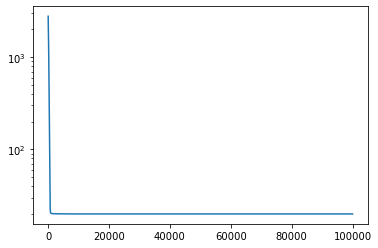

In [22]:
plt.semilogy(loss)
plt.show()

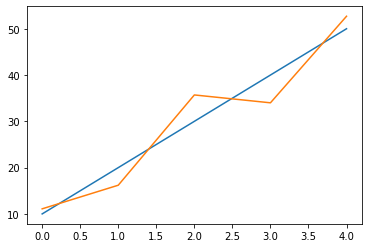

In [23]:
plt.plot(x_true.detach().numpy())
plt.plot(x_predict.detach().numpy())
plt.show()
